In [1]:
import pandas as pd
df = pd.read_csv('/content/anime_final.csv')
df.head()

,Unnamed: 0,series_animedb_id,title,episodes,score,rank,popularity,favorites,producers_81 Produce,producers_ABC Animation,...,studios_Sunrise,studios_Trigger,studios_White Fox,studios_Wit Studio,studios_asread.,studios_ufotable,demographics_Seinen,demographics_Shoujo,demographics_Shounen,my_score
0,0,42344,"Ame wo Matsu,",1.0,7.77,1076.0,8113.0,17.0,0,0,...,0,0,0,0,0,0,0,0,0,8
1,1,11111,Another,12.0,7.47,2023.0,59.0,17896.0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,2,24833,Ansatsu Kyoushitsu,22.0,8.08,539.0,34.0,30262.0,0,0,...,0,0,0,0,0,0,0,0,1,8
3,3,30654,Ansatsu Kyoushitsu 2nd Season,25.0,8.48,149.0,86.0,17699.0,0,0,...,0,0,0,0,0,0,0,0,1,9
4,4,5081,Bakemonogatari,15.0,8.32,256.0,94.0,49731.0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [7]:
df.columns

Index(['Unnamed: 0', 'series_animedb_id', 'title', 'episodes', 'score', 'rank',
       'popularity', 'favorites', 'producers_81 Produce',
       'producers_ABC Animation',
       ...
       'studios_Sunrise', 'studios_Trigger', 'studios_White Fox',
       'studios_Wit Studio', 'studios_asread.', 'studios_ufotable',
       'demographics_Seinen', 'demographics_Shoujo', 'demographics_Shounen',
       'my_score'],
      dtype='object', length=286)

In [8]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.shape

(121, 285)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import QuantileTransformer

def test_transformers(df, columns):
    qt = QuantileTransformer(n_quantiles=len(df), output_distribution='normal')

    n_rows = 9

    fig = plt.figure(figsize=(13, n_rows * 10))

    j = 1
    for i in columns:
        array = np.array(df[i]).reshape(-1, 1)
        y = qt.fit_transform(array)

        plt.subplot(n_rows, 3, j)
        sns.histplot(array, bins=50, kde=True)
        plt.title(f"Original Distribution for {i}")

        plt.subplot(n_rows, 3, j+2)
        sns.histplot(y, bins=50, kde=True)
        plt.title(f"Quantile Transform for {i}")

        j += 3

    plt.tight_layout()
    plt.show()


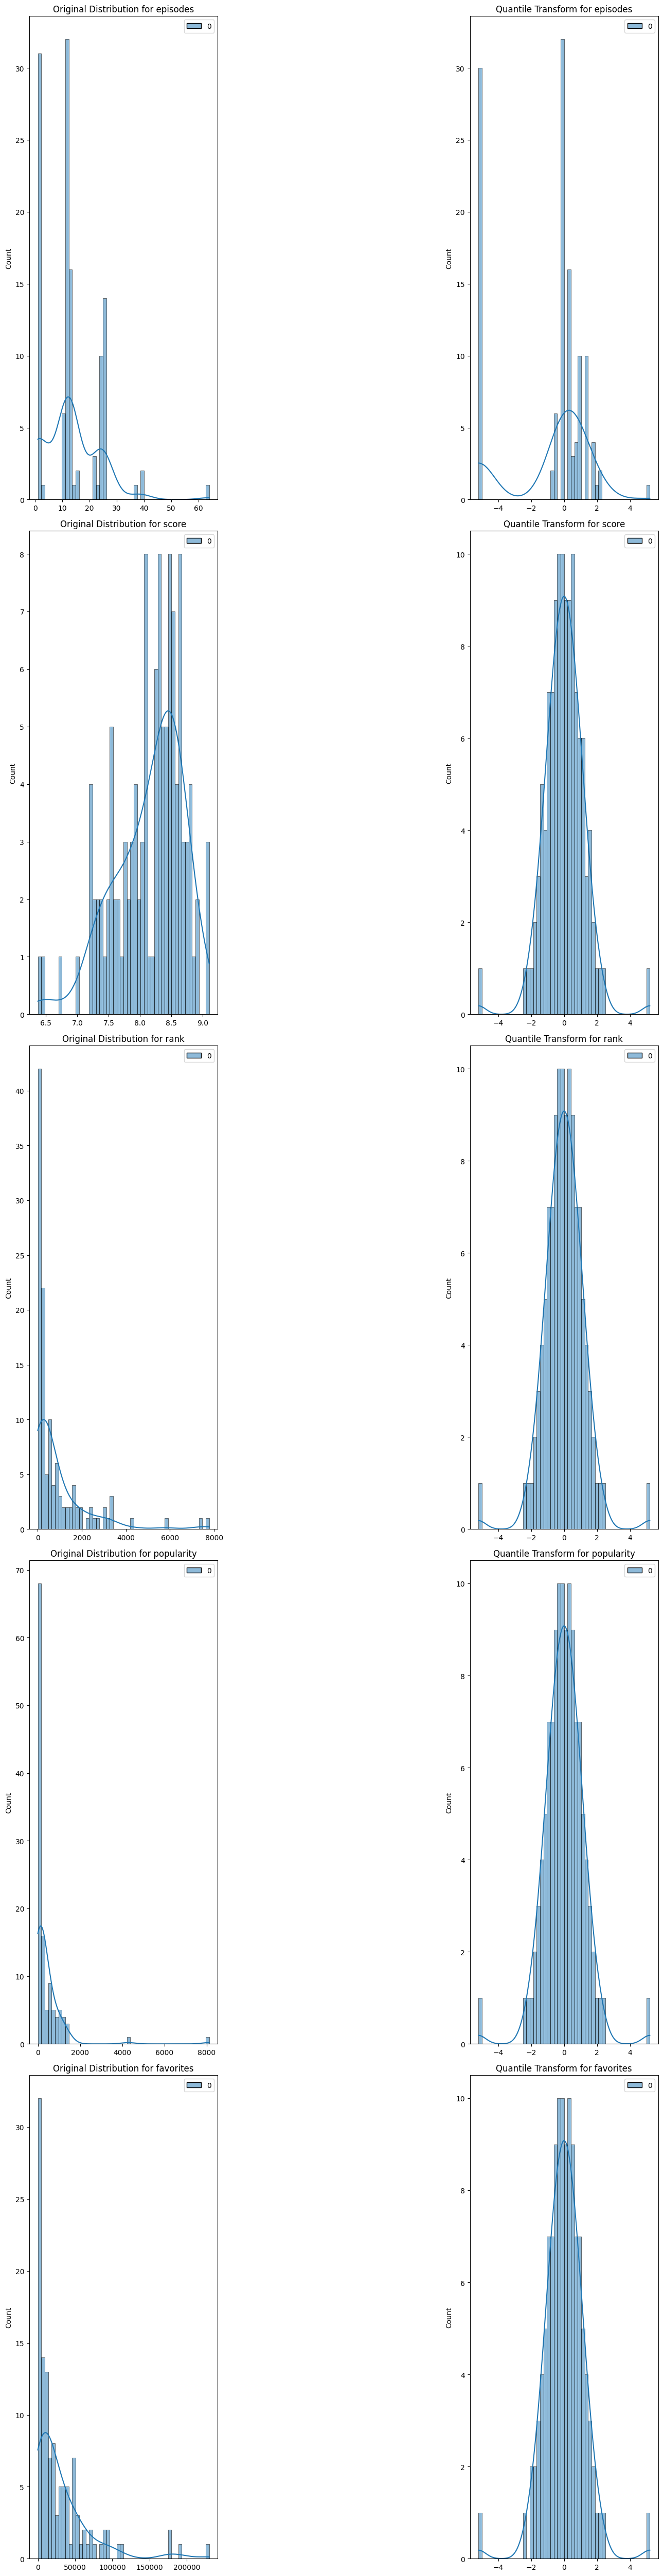

In [12]:
columns_to_standardize = ['episodes', 'score', 'rank', 'popularity', 'favorites']
test_transformers(df, columns_to_standardize)

In [13]:
from sklearn.model_selection import train_test_split

print("Dataset Size:", len(df))

train, temp = train_test_split(df, test_size=0.4)
dev, test = train_test_split(temp, test_size=0.5)

print("Training Size:", len(train))
print("Dev Set Size:", len(dev))
print("Test Size:", len(test))

Dataset Size: 121
Training Size: 72
Dev Set Size: 24
Test Size: 25


In [18]:
def preprocess_data(df, scaler, target_column, columns_to_standardize, fit=False):
    df_processed = df.drop(['series_animedb_id', 'title'], axis=1)

    X = df_processed.drop(target_column, axis=1)
    y = df_processed[target_column].values

    if fit:
        X[columns_to_standardize] = scaler.fit_transform(X[columns_to_standardize])
    else:
        X[columns_to_standardize] = scaler.transform(X[columns_to_standardize])

    X_bias = np.c_[np.ones(X.shape[0]), X]

    return X_bias, y

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [20]:
def evaluate_sklearn_models_with_gridsearch(df, scaler, target_column, columns_to_standardize, n_splits=5, random_state=42):
    param_grids = {
        "Ridge": {"alpha": [0.1, 1, 10, 15, 100]},
        "Lasso": {"alpha": [0.1, 1, 10, 15, 100]},
        "ElasticNet": {
            "alpha": [0.1, 1, 10, 15, 100],
            "l1_ratio": [0.1, 0.5, 0.9]
        },
        "LinearRegression": {}
    }

    models = {
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "ElasticNet": ElasticNet(),
        "LinearRegression": LinearRegression()
    }

    x_train_full, y_train_full = preprocess_data(df, scaler, target_column, columns_to_standardize, fit=True)

    results = []

    for model_name, model in models.items():
      print(f"\nEvaluating {model_name} with GridSearchCV...")
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
      train_mse_list = []
      dev_mse_list = []
      if param_grids[model_name]:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=kf, scoring='neg_mean_squared_error',n_jobs=-1)
        grid_search.fit(x_train_full[:,1:], y_train_full)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
      else:
            best_model = model
            best_params = "No hyperparameters to tune"
      print(f"Best parameters for {model_name}: {best_params}")

      for train_index, dev_index in kf.split(df):
          # Split the data
          train, dev = df.iloc[train_index], df.iloc[dev_index]

          # Preprocess data
          x_train, y_train = preprocess_data(train, scaler, target_column, columns_to_standardize, fit=True)
          x_dev, y_dev = preprocess_data(dev, scaler, target_column, columns_to_standardize)

          # Fit the model
          best_model.fit(x_train[:, 1:], y_train)

          # Make predictions on the training and dev sets
          y_pred_train = best_model.predict(x_train[:, 1:])
          y_pred_dev = best_model.predict(x_dev[:, 1:])

          # Calculate Mean Squared Error for training and dev sets
          mse_train = mean_squared_error(y_train, y_pred_train)
          mse_dev = mean_squared_error(y_dev, y_pred_dev)

          # Append the MSE values to the lists
          train_mse_list.append(mse_train)
          dev_mse_list.append(mse_dev)

      avg_train_mse = np.mean(train_mse_list)
      avg_dev_mse = np.mean(dev_mse_list)

      # Fit the model on the full dataset
      best_model.fit(x_train_full[:, 1:], y_train_full)

      # Store the results
      results.append({
          'Model': model_name,
          'Best Parameters': best_params,
          'Avg Train MSE': avg_train_mse,
          'Avg Dev MSE': avg_dev_mse,
      })
    results_df = pd.DataFrame(results)
    return results_df

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
target_column = 'my_score'
columns_to_standardize = ['episodes', 'score', 'rank', 'popularity', 'favorites']

results_df = evaluate_sklearn_models_with_gridsearch(df, scaler, target_column, columns_to_standardize)

sorted_results_df = results_df.sort_values('Avg Dev MSE', ascending=True)
sorted_results_df


Evaluating Ridge with GridSearchCV...
Best parameters for Ridge: {'alpha': 100}

Evaluating Lasso with GridSearchCV...
Best parameters for Lasso: {'alpha': 0.1}

Evaluating ElasticNet with GridSearchCV...
Best parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.1}

Evaluating LinearRegression with GridSearchCV...
Best parameters for LinearRegression: No hyperparameters to tune


,Model,Best Parameters,Avg Train MSE,Avg Dev MSE
2,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.1}",0.646093,1.454348e+00
0,Ridge,{'alpha': 100},1.090893,1.461002e+00
1,Lasso,{'alpha': 0.1},1.288030,1.481230e+00
3,LinearRegression,No hyperparameters to tune,0.001503,2.994627e+23


In [23]:
import requests
import json

def fetch_anime_info(anime_id):
    url = f'https://api.jikan.moe/v4/anime/{anime_id}/full'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()['data']
        else:
            print(f"Failed to fetch data for Anime ID: {anime_id}, Status Code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching data for Anime ID: {anime_id}: {e}")
        return None

def format_new_anime_data(anime_json):
    def format_data(entry):
        return ", ".join([item['name'] for item in entry]) if entry else "None"

    anime_formatted = {
        'title': anime_json['title'],
        'type': anime_json['type'],
        'source': anime_json['source'],
        'episodes': anime_json['episodes'],
        'rating': anime_json['rating'],
        'score': anime_json['score'],
        'rank': anime_json['rank'],
        'popularity': anime_json['popularity'],
        'favorites': anime_json['favorites'],
        'season': anime_json['season'],
        'year': anime_json['year'],
        'producers': format_data(anime_json.get('producers')),
        'licensors': format_data(anime_json.get('licensors')),
        'studios': format_data(anime_json.get('studios')),
        'genres': format_data(anime_json.get('genres')),
        'explicit_genres': format_data(anime_json.get('explicit_genres')),
        'themes': format_data(anime_json.get('themes')),
        'demographics': format_data(anime_json.get('demographics'))
    }

    return anime_formatted

In [24]:
def preprocess_custom(df, scaler, target_column, columns_to_standardize, fit=False):
    # Drop id and title
    df_processed = df.drop(['series_animedb_id', 'title'], axis=1)

    # Separate features and target
    X = df_processed.drop(target_column, axis=1)
    y = 0

    if fit:
        # Fit and transform the features specified
        X[columns_to_standardize] = scaler.fit_transform(X[columns_to_standardize])
    else:
        # Transform the features specified using the already fitted standardization
        X[columns_to_standardize] = scaler.transform(X[columns_to_standardize])

    # Add a bias term to the standardized data
    X_bias = np.c_[np.ones(X.shape[0]), X]

    return X_bias, y

In [25]:
# Function to split and encode multiple columns
def split_and_encode(df, column_names):
    encoded_dfs = []
    for column_name in column_names:
        # Ensure columns are strings
        df[column_name] = df[column_name].astype(str)
        # Split the column by comma and create a DataFrame of booleans
        encoded_df = df[column_name].str.get_dummies(sep=', ')
        # Prefix the column names to avoid conflicts
        encoded_df.columns = [f"{column_name}_{col}" for col in encoded_df.columns]
        encoded_dfs.append(encoded_df)
    # Concatenate all the encoded DataFrames
    return pd.concat(encoded_dfs, axis=1)

In [26]:
# Function to estimate rank using closest scores
def estimate_rank(row, non_nan_rows, k=4):
    # Calculate the absolute difference in scores
    non_nan_rows = non_nan_rows.copy()
    non_nan_rows['score_diff'] = abs(non_nan_rows['score'] - row['score'])
    # Get the k rows with the smallest score difference
    closest_scores = non_nan_rows.nsmallest(k, 'score_diff')
    # Calculate and return the average rank, rounded to the nearest integer
    return round(closest_scores['rank'].mean())

In [27]:
def preprocess_anime_data(df, formatted_anime_df, split_and_encode, preprocess_custom, qt):
    # Read the original feature DataFrame and drop irrelevant columns
    original_features = df

    # Create a dummy DataFrame with zero-filled rows based on the columns of df_features
    dummy_df = pd.DataFrame(0, index=np.arange(1), columns=original_features.columns)

    # Split and Encode Catergoircal Features
    columns_to_encode = ['producers', 'genres', 'explicit_genres', 'themes']
    encoded_columns = split_and_encode(formatted_anime_df, columns_to_encode)

    encoded_columns = encoded_columns.rename(columns={"explicit_genres_None": "explicit_genres_nan"})

    # Merge encoded columns back to the main DataFrame
    formatted_anime_df.drop(columns_to_encode, axis=1, inplace=True)
    formatted_anime_df = pd.concat([formatted_anime_df, encoded_columns], axis=1)

    # List of other categorical features
    categorical_features = ['year', 'type', 'source', 'rating', 'season', 'licensors', 'studios', 'demographics']

    # Perform One-Hot Encoding on other categorical features
    formatted_anime_df = pd.get_dummies(formatted_anime_df, columns=categorical_features, dtype=int)

    # Rename year columns to add .0
    year_columns = [col for col in formatted_anime_df.columns if col.startswith('year_')]
    formatted_anime_df.rename(columns={col: f"{col}.0" for col in year_columns}, inplace=True)

    # Align formatted_anime_df columns to match dummy_df
    common_columns = dummy_df.columns.intersection(formatted_anime_df.columns)
    filtered_anime_df = formatted_anime_df[common_columns]

    # Append filtered_anime_df to the empty dummy_df
    df_features = pd.concat([dummy_df, filtered_anime_df], ignore_index=True)

    # Drop the initial zero-filled row used to create the structure
    df_features = df_features.drop(0).reset_index(drop=True)

    # Estimate ranks for rows with NaN rank
    nan_rows = df_features[df_features['rank'].isna()]
    non_nan_rows = df.dropna(subset=['rank'])
    for idx, row in nan_rows.iterrows():
        estimated_rank = estimate_rank(row, non_nan_rows)
        df_features.loc[idx, 'rank'] = estimated_rank

    # Drop the temporary 'score_diff' column if it exists
    if 'score_diff' in df_features.columns:
        df_features.drop(columns=['score_diff'], inplace=True)

    # Fill Remaining NaN values with 0
    df_features = df_features.fillna(0)

    # Preprocess
    columns_to_standardize = ['episodes', 'score', 'rank', 'popularity', 'favorites']

    custom, _ = preprocess_custom(df_features, scaler, 'my_score', columns_to_standardize)

    return df_features, custom, formatted_anime_df['title']

In [28]:
def process_single_show(anime_id, df, split_and_encode, preprocess_custom, scaler, theta):
    raw_anime_data = fetch_anime_info(anime_id)

    if raw_anime_data:
        formatted_anime_data = format_new_anime_data(raw_anime_data)
        formatted_anime_df = pd.DataFrame([formatted_anime_data])
        custom_preprocessed_df, custom, title = preprocess_anime_data(df, formatted_anime_df, split_and_encode, preprocess_custom, scaler)

        y_pred_custom = custom.dot(theta)

        result_df = pd.DataFrame({'Title': title, 'Predicted Score': y_pred_custom})
        return result_df
    else:
        print("No data found for the given Anime ID.")
        return pd.DataFrame(columns=['Title', 'Predicted Score'])

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Perform k-fold cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, dev_index in kf.split(df):
    train, dev = df.iloc[train_index], df.iloc[dev_index]

# Inspect Dataset Sizes
print("Training Size:", len(train))
print("Dev Size:", len(dev))

Training Size: 97
Dev Size: 24


In [36]:
def gradient_descent(x_train, y_train, x_dev, y_dev, lr, lambd, epochs, fold, print_epochs, print_count=5):



  """
  Perform gradient descent for multiple linear regression.

  Parameters:
  x_train (numpy.ndarray): Training dataset features.
  y_train (numpy.ndarray): Training dataset targets.
  x_dev (numpy.ndarray): Validation (development) dataset features.
  y_dev (numpy.ndarray): Validation (development) dataset targets.
  lr (float): Learning rate for gradient descent.
  lambd (float): Regularization parameter (lambda).
  epochs (int): Number of iterations for gradient descent.
  fold (int): Current fold number in cross-validation.
  print_epochs (bool): Flag to print loss during training.
  print_count (int): Number of times to print the loss during training (default is 5).

  Returns:
  tuple: Updated weights (theta), training loss history, validation loss history,
          lowest validation loss, epoch at lowest validation loss.
  """
  # Initialize weights
  m, n = x_train.shape
  theta = np.zeros(n)

  # Store Loss
  train_history = []
  dev_history = []

  # Store Results
  results = []

  for i in range(epochs):
    # Get Predictions
    y_pred = x_train.dot(theta)
    y_pred_dev = x_dev.dot(theta)

    # Calculate Gradients
    regularization = lambd * theta[1:]
    gradients = (2/m) * (x_train.T.dot(y_pred - y_train) + np.concatenate(([0], regularization)))
    gradients = gradients.astype(float)

    # Update Weights
    theta -= lr * gradients

    # Calculate Loss
    train_loss = np.mean((y_train - y_pred) ** 2)
    dev_loss = np.mean((y_dev - y_pred_dev) ** 2)

    # Print Loss print_count times
    if (print_epochs and (i % round(epochs/print_count) == 0)) or (print_epochs and (i == epochs-1)):
        results.append({
            'Fold': fold,
            'Epoch': i,
            'Train Loss': f"{train_loss:.4f}",
            'Dev Loss': f"{dev_loss:.4f}",
        })

        print(f"\n{results[-1]}")
    # Append Loss History
    train_history.append(train_loss)
    dev_history.append(dev_loss)

    # Show Lowest Loss and Epoch
    if i == epochs-1:
        lowest_train_loss = min(train_history)
        lowest_train_epoch = train_history.index(lowest_train_loss)
        lowest_dev_loss = min(dev_history)
        lowest_dev_epoch = dev_history.index(lowest_dev_loss)

  return (theta, train_history, dev_history, lowest_train_loss, lowest_train_epoch, lowest_dev_loss, lowest_dev_epoch)


In [39]:
def kfold_gradient_descent(df, scaler, lr, lambd, epochs, n_splits, print_epochs, print_count, prev_mean_train_loss, prev_mean_dev_loss, prev_final_train_loss, prev_final_dev_loss):
  """
  Perform K-Fold cross-validation gradient descent for multiple linear regression.

  Parameters:
  scaler (object): Scaler object used for data preprocessing.
  lr (float): Learning rate for gradient descent.
  lambd (float): Regularization parameter (lambda).
  epochs (int): Number of iterations for gradient descent.
  n_splits (int): Number of folds for K-Fold cross-validation.
  print_epochs (bool): Flag to print loss during training.
  print_count (int): Number of times to print the loss during training.
  prev_mean_train_loss (float or str): Previous mean training loss for comparison.
  prev_mean_dev_loss (float or str): Previous mean validation loss for comparison.
  prev_final_train_loss (float or str): Previous final training loss for comparison on the full dataset.
  prev_final_dev_loss (float or str): Previous final validation loss for comparison on the full dataset.

  Returns:
  tuple: Updated weights (theta), all training loss histories, all validation loss histories,
          mean final training loss, mean final validation loss, mean of the lowest validation losses,
          mean epoch of the lowest validation losses, full training history, full validation history.
  """
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  all_train_history, all_dev_history = [], []
  final_train_losses, final_dev_losses = [], []

  all_lowest_train_loss, all_lowest_train_epoch = [], []
  all_lowest_dev_loss, all_lowest_dev_epoch = [], []

  fold = 0

  for train_index, dev_index in kf.split(df):
      print(f"\nFold {fold + 1}/{n_splits}")
      train, dev = df.iloc[train_index], df.iloc[dev_index]

      # Set Target Column
      target_column = df.columns[-1]

      # Separate titles for each set
      train_titles = train['title']
      test_titles = dev['title']

      columns_to_standardize = ['episodes', 'score', 'rank', 'popularity', 'favorites']

      x_train, y_train = preprocess_data(train, scaler, target_column, columns_to_standardize, fit=True)
      x_dev, y_dev = preprocess_data(dev, scaler, target_column, columns_to_standardize)

      # Train on KFold Split
      (theta, train_history, dev_history,lowest_train_loss, lowest_train_epoch,lowest_dev_loss, lowest_dev_epoch) = gradient_descent(x_train, y_train, x_dev, y_dev, lr, lambd, epochs, fold, print_epochs, print_count)



      # Append KFold Loss History
      all_train_history.append(train_history)
      all_dev_history.append(dev_history)

      # Append Final Losses
      final_train_losses.append(train_history[-1])
      final_dev_losses.append(dev_history[-1])

      # Append Lowest Train/Dev Loss and Epoch
      all_lowest_train_loss.append(lowest_train_loss)
      all_lowest_train_epoch.append(lowest_train_epoch)
      all_lowest_dev_loss.append(lowest_dev_loss)
      all_lowest_dev_epoch.append(lowest_dev_epoch)

      fold += 1
  # Train on full Dataset
  x_train_full, y_train_full = preprocess_data(df, scaler, target_column, columns_to_standardize, fit=True)

  # Final Training on Full Dataset
  (theta, full_train_history, full_dev_history,lowest_train_loss, lowest_train_epoch,lowest_dev_loss, lowest_dev_epoch) = gradient_descent(x_train_full, y_train_full, x_dev, y_dev, lr, lambd, epochs, fold, print_epochs, print_count)


  # Calculate Mean of Final Losses
  mean_final_train_loss = np.mean(final_train_losses)
  mean_final_dev_loss = np.mean(final_dev_losses)

  print(f"\nMean Train/Dev Loss: Train: {mean_final_train_loss:.4f}, Dev: {mean_final_dev_loss:.4f}")

  # Compare to Previous Mean
  if prev_mean_train_loss != "_":
      print(f"Mean Compared to Previous Run: Train: {(mean_final_train_loss-prev_mean_train_loss):.4f}, Dev: {(mean_final_dev_loss-prev_mean_dev_loss):.4f}")

  # Print full Losses on Full Dataset
  full_final_train_loss = full_train_history[-1]
  full_final_dev_loss = full_dev_history[-1]
  print(f"\nFinal Losses on Full Dataset: Train: {full_final_train_loss:.4f}, Dev: {full_final_dev_loss:.4f}")

  # Compare to Previous Final
  if prev_final_train_loss != "_":
      print(f"Final Compared to Previous Run: Train: {(full_final_train_loss-prev_final_train_loss):.4f}, Dev: {(full_final_dev_loss-prev_final_dev_loss):.4f}")

  # Calculate Mean of Best Train/Dev Losses
  mean_best_train_loss = np.mean(all_lowest_train_loss)
  mean_best_train_epoch = np.mean(all_lowest_train_epoch)

  mean_best_dev_loss = np.mean(all_lowest_dev_loss)
  mean_best_dev_epoch = np.mean(all_lowest_dev_epoch)

  print(f"\nAverage Best Train Loss and Epoch: Loss: {mean_best_train_loss:.4f}, Epoch: {mean_best_train_epoch}")
  print(f"Average Best Dev Loss and Epoch: Loss: {mean_best_dev_loss:.4f}, Epoch: {mean_best_dev_epoch}")

  return (theta, all_train_history, all_dev_history, mean_final_train_loss, mean_final_dev_loss,mean_best_train_loss, mean_best_train_epoch,mean_best_dev_loss, mean_best_dev_epoch, full_train_history, full_dev_history)

In [40]:
# Set Standardization
scaler = StandardScaler()

# Set Hyperparameters
lr = 0.005
lambd = 0
epochs = 5000

# Set Number of Splits
n_splits = 5

# Set Loss Printing Params
print_epochs = True
print_count = 1

# Temporarily Set Previous Run
prev_mean_train_loss = "_"
prev_mean_dev_loss = "_"

prev_final_train_loss = "_"
prev_final_dev_loss = "_"

# Run KFolds
(theta, all_train_history, all_dev_history, prev_mean_train_loss, prev_mean_dev_loss,mean_best_train_loss, mean_best_train_epoch,mean_best_dev_loss, mean_best_dev_epoch,full_train_history, full_dev_history) = kfold_gradient_descent(df, scaler, lr, lambd, epochs,n_splits, print_epochs, print_count, prev_mean_train_loss, prev_mean_dev_loss,prev_final_train_loss, prev_final_dev_loss)



Fold 1/5

{'Fold': 0, 'Epoch': 0, 'Train Loss': '57.2500', 'Dev Loss': '53.4000'}

{'Fold': 0, 'Epoch': 4999, 'Train Loss': '0.1509', 'Dev Loss': '1.4325'}

Fold 2/5

{'Fold': 1, 'Epoch': 0, 'Train Loss': '56.4433', 'Dev Loss': '56.5000'}

{'Fold': 1, 'Epoch': 4999, 'Train Loss': '0.1322', 'Dev Loss': '2.5843'}

Fold 3/5

{'Fold': 2, 'Epoch': 0, 'Train Loss': '55.8041', 'Dev Loss': '59.0833'}

{'Fold': 2, 'Epoch': 4999, 'Train Loss': '0.0832', 'Dev Loss': '2.9344'}

Fold 4/5

{'Fold': 3, 'Epoch': 0, 'Train Loss': '55.6598', 'Dev Loss': '59.6667'}

{'Fold': 3, 'Epoch': 4999, 'Train Loss': '0.1646', 'Dev Loss': '2.8054'}

Fold 5/5

{'Fold': 4, 'Epoch': 0, 'Train Loss': '57.1237', 'Dev Loss': '53.7500'}

{'Fold': 4, 'Epoch': 4999, 'Train Loss': '0.1703', 'Dev Loss': '1.2616'}

{'Fold': 5, 'Epoch': 0, 'Train Loss': '56.4545', 'Dev Loss': '53.7500'}

{'Fold': 5, 'Epoch': 4999, 'Train Loss': '0.2214', 'Dev Loss': '0.1570'}

Mean Train/Dev Loss: Train: 0.1402, Dev: 2.2036

Final Losses on Fu

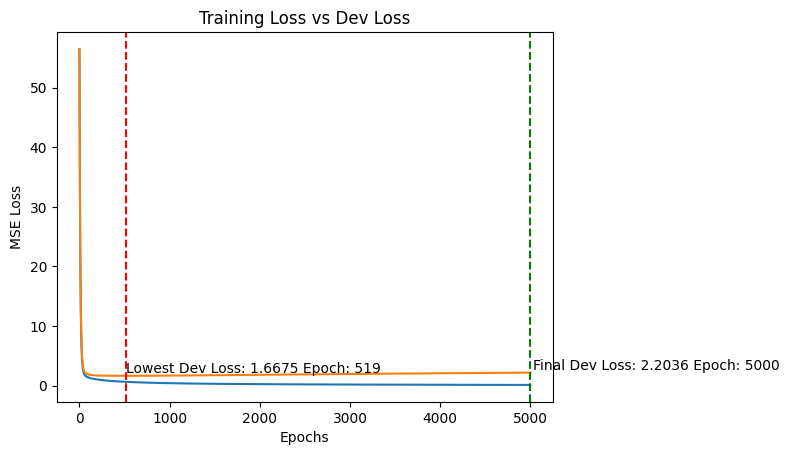

In [41]:
# Compute average loss histories
average_train_history = np.mean(all_train_history, axis=0)
average_dev_history = np.mean(all_dev_history, axis=0)

# Compare train and dev loss
lowest_dev_loss = min(average_dev_history)
lowest_dev_epoch = np.argmin(average_dev_history)

final_dev_loss = average_dev_history[-1]
final_dev_epoch = final_loss_epoch = len(average_dev_history)

plt.plot(range(len(average_train_history)), average_train_history)
plt.plot(range(len(average_dev_history)), average_dev_history)

plt.axvline(x=lowest_dev_epoch, color='r', linestyle='--', label='Lowest Dev Loss')
plt.text(lowest_dev_epoch*1.005, lowest_dev_loss, f'Lowest Dev Loss: {lowest_dev_loss:.4f} Epoch: {lowest_dev_epoch}', color='black', verticalalignment='bottom')

plt.axvline(x=final_dev_epoch, color='green', linestyle='--', label='Final Dev Loss')
plt.text(final_dev_epoch*1.005, final_dev_loss, f'Final Dev Loss: {final_dev_loss:.4f} Epoch: {final_dev_epoch}', color='black', verticalalignment='bottom')

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Dev Loss')

plt.show()

In [42]:
# Set Standardization
scaler = QuantileTransformer(n_quantiles=96, output_distribution='normal')

# Set Hyperparameters
lr = 0.005
lambd = 0
epochs = 5000

# Set Number of Splits
n_splits = 5

# Set Loss Printing Params
print_epochs = True
print_count = 1

# Set Previous Final Losses
prev_final_train_loss = full_train_history[-1]
prev_final_dev_loss = full_dev_history[-1]

# Run KFolds
(theta,
 all_train_history, all_dev_history,
 prev_final_train_loss, prev_final_dev_loss,
 mean_best_train_loss, mean_best_train_epoch,
 mean_best_dev_loss, mean_best_dev_epoch,
 full_train_history, full_dev_history) = kfold_gradient_descent(df, scaler, lr, lambd, epochs,n_splits, print_epochs, print_count, prev_mean_train_loss, prev_mean_dev_loss,prev_final_train_loss, prev_final_dev_loss)



Fold 1/5

{'Fold': 0, 'Epoch': 0, 'Train Loss': '57.2500', 'Dev Loss': '53.4000'}

{'Fold': 0, 'Epoch': 4999, 'Train Loss': '0.1440', 'Dev Loss': '1.2482'}

Fold 2/5

{'Fold': 1, 'Epoch': 0, 'Train Loss': '56.4433', 'Dev Loss': '56.5000'}

{'Fold': 1, 'Epoch': 4999, 'Train Loss': '0.1293', 'Dev Loss': '2.3429'}

Fold 3/5

{'Fold': 2, 'Epoch': 0, 'Train Loss': '55.8041', 'Dev Loss': '59.0833'}

{'Fold': 2, 'Epoch': 4999, 'Train Loss': '0.0779', 'Dev Loss': '2.4710'}

Fold 4/5

{'Fold': 3, 'Epoch': 0, 'Train Loss': '55.6598', 'Dev Loss': '59.6667'}

{'Fold': 3, 'Epoch': 4999, 'Train Loss': '0.1448', 'Dev Loss': '2.5226'}

Fold 5/5

{'Fold': 4, 'Epoch': 0, 'Train Loss': '57.1237', 'Dev Loss': '53.7500'}

{'Fold': 4, 'Epoch': 4999, 'Train Loss': '0.1777', 'Dev Loss': '1.0588'}

{'Fold': 5, 'Epoch': 0, 'Train Loss': '56.4545', 'Dev Loss': '53.7500'}

{'Fold': 5, 'Epoch': 4999, 'Train Loss': '0.2148', 'Dev Loss': '0.1471'}

Mean Train/Dev Loss: Train: 0.1347, Dev: 1.9287
Mean Compared to Pr

In [43]:
# Set Standardization
scaler = QuantileTransformer(n_quantiles=96, output_distribution='normal')

# Set Hyperparameters
lr = 0.005
lambd = 10   # Set to 10
epochs = 5000

# Set Number of Splits
n_splits = 5

# Set Loss Printing Params
print_epochs = True
print_count = 1

# Set Previous Final Losses
prev_final_train_loss = full_train_history[-1]
prev_final_dev_loss = full_dev_history[-1]

# Run KFolds
(theta,
 all_train_history, all_dev_history,
 prev_final_train_loss, prev_final_dev_loss,
 mean_best_train_loss, mean_best_train_epoch,
 mean_best_dev_loss, mean_best_dev_epoch,
 full_train_history, full_dev_history) = kfold_gradient_descent(df, scaler, lr, lambd, epochs,n_splits, print_epochs, print_count, prev_mean_train_loss, prev_mean_dev_loss,prev_final_train_loss, prev_final_dev_loss)


Fold 1/5

{'Fold': 0, 'Epoch': 0, 'Train Loss': '57.2500', 'Dev Loss': '53.4000'}

{'Fold': 0, 'Epoch': 4999, 'Train Loss': '0.5176', 'Dev Loss': '1.0763'}

Fold 2/5

{'Fold': 1, 'Epoch': 0, 'Train Loss': '56.4433', 'Dev Loss': '56.5000'}

{'Fold': 1, 'Epoch': 4999, 'Train Loss': '0.4753', 'Dev Loss': '1.9172'}

Fold 3/5

{'Fold': 2, 'Epoch': 0, 'Train Loss': '55.8041', 'Dev Loss': '59.0833'}

{'Fold': 2, 'Epoch': 4999, 'Train Loss': '0.4095', 'Dev Loss': '1.5787'}

Fold 4/5

{'Fold': 3, 'Epoch': 0, 'Train Loss': '55.6598', 'Dev Loss': '59.6667'}

{'Fold': 3, 'Epoch': 4999, 'Train Loss': '0.4725', 'Dev Loss': '1.8050'}

Fold 5/5

{'Fold': 4, 'Epoch': 0, 'Train Loss': '57.1237', 'Dev Loss': '53.7500'}

{'Fold': 4, 'Epoch': 4999, 'Train Loss': '0.5618', 'Dev Loss': '0.7724'}

{'Fold': 5, 'Epoch': 0, 'Train Loss': '56.4545', 'Dev Loss': '53.7500'}

{'Fold': 5, 'Epoch': 4999, 'Train Loss': '0.5238', 'Dev Loss': '0.3389'}

Mean Train/Dev Loss: Train: 0.4873, Dev: 1.4299
Mean Compared to Pr

In [44]:
import pickle

def save_model_parameters(theta, lr, lambd):
    filename = f'model_lr_{lr}_lambda_{lambd}.pkl'
    with open (filename, 'wb') as file:
        pickle.dump(theta, file)
    print(f"\nModel parameters saved to {filename}")

In [45]:
def find_best_hyperparameters(df, scaler, lr_list, lambda_list, epochs,n_splits, print_epochs, print_count, full_train_history, full_dev_history):
  """
  Find the best hyperparameters for gradient descent using K-Fold cross-validation.

  Parameters:
  scaler (object): Scaler object used for data preprocessing.
  lr_list (list): List of learning rates to test.
  lambda_list (list): List of regularization parameters (lambda) to test.
  epochs (int): Number of iterations for gradient descent.
  n_splits (int): Number of folds for K-Fold cross-validation.
  print_epochs (bool): Flag to print loss during training.
  print_count (int): Number of times to print the loss during training.
  full_train_history (list): Full training loss history from previous runs.
  full_dev_history (list): Full validation loss history from previous runs.

  Returns:
  tuple: Best learning rate (best_lr), best lambda (best_lambda),
          lowest average validation loss (lowest_avg_dev_loss),
          epoch with the best average validation loss (best_epoch),
          DataFrame of all results (results_df).
  """
  best_lr = None
  best_lambda = None
  lowest_avg_train_loss = float('inf')
  best_train_epoch = None
  lowest_avg_dev_loss = float('inf')
  best_dev_epoch = None

  # Store Results
  results = []

  # Loop Through Hyperparameter Lists
  for lr in lr_list:
      for lambd in lambda_list:
          print(f"\n-----------------------------------------------------------------")
          print(f"\nTraining with lr={lr} and lambda={lambd}")

          if full_train_history:
              # Set Previous Final Losses
              prev_final_train_loss = full_train_history[-1]
              prev_final_dev_loss = full_dev_history[-1]
          else:
              prev_final_train_loss = "_"
              prev_final_dev_loss = "_"
          # Run KFold Gradient Descent with Hyperparameters
          (theta,
            all_train_history, all_dev_history,
            prev_final_train_loss, prev_final_dev_loss,
            mean_best_train_loss, mean_best_train_epoch,
            mean_best_dev_loss, mean_best_dev_epoch,
            full_train_history, full_dev_history) = kfold_gradient_descent(df, scaler, lr, lambd, epochs,n_splits, print_epochs, print_count, prev_mean_train_loss, prev_mean_dev_loss,prev_final_train_loss, prev_final_dev_loss)
          # Save Model parameters
          save_model_parameters(theta, lr, lambd)

          # Store the results
          results.append({
              'lr': lr,
              'lambda': lambd,
              'mean_final_train_loss': prev_final_train_loss,
              'mean_final_dev_loss': prev_final_dev_loss,
              'mean_best_train_loss': mean_best_train_loss,
              'mean_best_train_epoch': mean_best_train_epoch,
              'mean_best_dev_loss': mean_best_dev_loss,
              'mean_best_dev_epoch': mean_best_dev_epoch,
              'full_train_loss': full_train_history[-1],
              'full_dev_loss': full_dev_history[-1]
          })

           # Update the best hyperparameters if current average dev loss is lower than the best so far
          if prev_final_dev_loss < lowest_avg_dev_loss:
              best_theta = theta
              best_lr = lr
              best_lambda = lambd
              lowest_avg_train_loss = mean_best_train_loss
              lowest_avg_dev_loss = mean_best_dev_loss
              best_train_epoch = round(mean_best_train_epoch)
              best_dev_epoch = round(mean_best_dev_epoch)

  results_df = pd.DataFrame(results)

  print(f"\nBest Learning Rate: {best_lr}")
  print(f"\nBest Lambda: {best_lambda}")
  print(f"\nLowest Avg Train Loss: {lowest_avg_train_loss} at Epoch: {best_train_epoch}")
  print(f"\nLowest Avg Dev Loss: {lowest_avg_dev_loss} at Epoch: {best_dev_epoch}")

  return (best_theta,best_lr, best_lambda, lowest_avg_train_loss, best_train_epoch, lowest_avg_dev_loss, best_dev_epoch, results_df)


In [46]:
# Set Standardization
scaler = QuantileTransformer(n_quantiles=96, output_distribution='normal')

# Set Hyperparameter Lists
learning_rates = [0.001, 0.005]
lambda_list = [0.1, 1, 10]
epochs = 5000

# Set Number of Splits
n_splits = 5

# Set Loss Printing Params
print_epochs = True
print_count = 1

# Find the best hyperparameters
(best_theta,
 best_lr, best_lambd,
 lowest_avg_train_loss, best_train_epoch,
 lowest_avg_dev_loss, best_dev_epoch,
 results_df) = find_best_hyperparameters(df, scaler,
                                         learning_rates, lambda_list, epochs,
                                         n_splits, print_epochs, print_count,
                                         full_train_history, full_dev_history)


-----------------------------------------------------------------

Training with lr=0.001 and lambda=0.1

Fold 1/5

{'Fold': 0, 'Epoch': 0, 'Train Loss': '57.2500', 'Dev Loss': '53.4000'}

{'Fold': 0, 'Epoch': 4999, 'Train Loss': '0.4698', 'Dev Loss': '1.2301'}

Fold 2/5

{'Fold': 1, 'Epoch': 0, 'Train Loss': '56.4433', 'Dev Loss': '56.5000'}

{'Fold': 1, 'Epoch': 4999, 'Train Loss': '0.4201', 'Dev Loss': '2.3359'}

Fold 3/5

{'Fold': 2, 'Epoch': 0, 'Train Loss': '55.8041', 'Dev Loss': '59.0833'}

{'Fold': 2, 'Epoch': 4999, 'Train Loss': '0.3454', 'Dev Loss': '1.6451'}

Fold 4/5

{'Fold': 3, 'Epoch': 0, 'Train Loss': '55.6598', 'Dev Loss': '59.6667'}

{'Fold': 3, 'Epoch': 4999, 'Train Loss': '0.4293', 'Dev Loss': '1.9325'}

Fold 5/5

{'Fold': 4, 'Epoch': 0, 'Train Loss': '57.1237', 'Dev Loss': '53.7500'}

{'Fold': 4, 'Epoch': 4999, 'Train Loss': '0.4991', 'Dev Loss': '0.8320'}

{'Fold': 5, 'Epoch': 0, 'Train Loss': '56.4545', 'Dev Loss': '53.7500'}

{'Fold': 5, 'Epoch': 4999, 'Train L

In [47]:
results_df

,lr,lambda,mean_final_train_loss,mean_final_dev_loss,mean_best_train_loss,mean_best_train_epoch,mean_best_dev_loss,mean_best_dev_epoch,full_train_loss,full_dev_loss
0,0.001,0.1,0.432755,1.595130,0.432755,4999.0,1.484940,3967.8,0.529735,0.360822
1,0.001,1.0,0.450046,1.587892,0.450046,4999.0,1.485044,4027.0,0.543484,0.368192
2,0.001,10.0,0.622993,1.560160,0.622993,4999.0,1.505661,4139.6,0.681160,0.442012
3,0.005,0.1,0.138349,1.907757,0.138349,4999.0,1.447384,1360.8,0.218060,0.148774
4,0.005,1.0,0.175267,1.758197,0.175267,4999.0,1.435460,1705.2,0.249422,0.165989
5,0.005,10.0,0.487348,1.429906,0.487348,4999.0,1.351133,3691.2,0.523789,0.338872


In [48]:
# Set Standardization
scaler = QuantileTransformer(n_quantiles=96, output_distribution='normal')

# Set Hyperparameter Lists
learning_rates = [0.0025, 0.005, 0.01]
lambda_list = [5, 10, 15]
epochs = 5000

# Set Number of Splits
n_splits = 5

# Set Loss Printing Params
print_epochs = True
print_count = 1

# Find the best hyperparameters
(best_theta,
 best_lr, best_lambd,
 lowest_avg_train_loss, best_train_epoch,
 lowest_avg_dev_loss, best_dev_epoch, results_df) = find_best_hyperparameters(df, scaler,
                                                                              learning_rates, lambda_list, epochs,
                                                                              n_splits, print_epochs, print_count,
                                                                              full_train_history, full_dev_history)


-----------------------------------------------------------------

Training with lr=0.0025 and lambda=5

Fold 1/5

{'Fold': 0, 'Epoch': 0, 'Train Loss': '57.2500', 'Dev Loss': '53.4000'}

{'Fold': 0, 'Epoch': 4999, 'Train Loss': '0.4110', 'Dev Loss': '1.1258'}

Fold 2/5

{'Fold': 1, 'Epoch': 0, 'Train Loss': '56.4433', 'Dev Loss': '56.5000'}

{'Fold': 1, 'Epoch': 4999, 'Train Loss': '0.3662', 'Dev Loss': '2.1113'}

Fold 3/5

{'Fold': 2, 'Epoch': 0, 'Train Loss': '55.8041', 'Dev Loss': '59.0833'}

{'Fold': 2, 'Epoch': 4999, 'Train Loss': '0.2981', 'Dev Loss': '1.7017'}

Fold 4/5

{'Fold': 3, 'Epoch': 0, 'Train Loss': '55.6598', 'Dev Loss': '59.6667'}

{'Fold': 3, 'Epoch': 4999, 'Train Loss': '0.3792', 'Dev Loss': '1.9011'}

Fold 5/5

{'Fold': 4, 'Epoch': 0, 'Train Loss': '57.1237', 'Dev Loss': '53.7500'}

{'Fold': 4, 'Epoch': 4999, 'Train Loss': '0.4450', 'Dev Loss': '0.7727'}

{'Fold': 5, 'Epoch': 0, 'Train Loss': '56.4545', 'Dev Loss': '53.7500'}

{'Fold': 5, 'Epoch': 4999, 'Train Lo

In [49]:
def load_model_parameters(filename):
    with open(filename, 'rb') as file:
        theta = pickle.load(file)
    print(f"Model parameters loaded from {filename}")
    return theta

In [50]:
#Construct the filename for the best model
best_model_filename = f'model_lr_{best_lr}_lambda_{best_lambd}.pkl'

# Load the best model parameters
best_theta = load_model_parameters(best_model_filename)

Model parameters loaded from model_lr_0.0025_lambda_5.pkl


In [51]:
(early_theta,
 all_train_history, all_dev_history,
 prev_final_train_loss, prev_final_dev_loss,
 mean_best_train_loss, mean_best_train_epoch,
 mean_best_dev_loss, mean_best_dev_epoch,
 full_train_history, full_dev_history) = kfold_gradient_descent(df, scaler,
                                                                best_lr, best_lambd, best_dev_epoch,
                                                                n_splits, print_epochs, print_count,
                                                                prev_mean_train_loss, prev_mean_dev_loss,
                                                                prev_final_train_loss, prev_final_dev_loss)

# Save Model parameters
save_model_parameters(early_theta, best_lr, best_lambd)


Fold 1/5

{'Fold': 0, 'Epoch': 0, 'Train Loss': '57.2500', 'Dev Loss': '53.4000'}

{'Fold': 0, 'Epoch': 3652, 'Train Loss': '0.4482', 'Dev Loss': '1.1530'}

Fold 2/5

{'Fold': 1, 'Epoch': 0, 'Train Loss': '56.4433', 'Dev Loss': '56.5000'}

{'Fold': 1, 'Epoch': 3652, 'Train Loss': '0.4005', 'Dev Loss': '2.1794'}

Fold 3/5

{'Fold': 2, 'Epoch': 0, 'Train Loss': '55.8041', 'Dev Loss': '59.0833'}

{'Fold': 2, 'Epoch': 3652, 'Train Loss': '0.3317', 'Dev Loss': '1.6578'}

Fold 4/5

{'Fold': 3, 'Epoch': 0, 'Train Loss': '55.6598', 'Dev Loss': '59.6667'}

{'Fold': 3, 'Epoch': 3652, 'Train Loss': '0.4111', 'Dev Loss': '1.8971'}

Fold 5/5

{'Fold': 4, 'Epoch': 0, 'Train Loss': '57.1237', 'Dev Loss': '53.7500'}

{'Fold': 4, 'Epoch': 3652, 'Train Loss': '0.4815', 'Dev Loss': '0.7822'}

{'Fold': 5, 'Epoch': 0, 'Train Loss': '56.4545', 'Dev Loss': '53.7500'}

{'Fold': 5, 'Epoch': 3652, 'Train Loss': '0.4795', 'Dev Loss': '0.3125'}

Mean Train/Dev Loss: Train: 0.4146, Dev: 1.5339
Mean Compared to Pr

In [52]:
def plot_loss(loss_history, lowest_loss, final_loss, set_name):
    # Find the epoch where the lowest/final loss occurs
    lowest_loss_epoch = np.argmin(loss_history)
    final_loss_epoch = len(loss_history)

    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label=f'{set_name} Loss')

    # Plot vertical line at the epoch of the lowest loss
    plt.axvline(x=lowest_loss_epoch, color='r', linestyle='--', label=f'Lowest {set_name} Loss')
    plt.text(lowest_loss_epoch*1.01, lowest_loss, f'Lowest {set_name} Loss: {lowest_loss:.4f}', color='black', verticalalignment='bottom')

    # Plot vertical line at the epoch of the lowest final
    plt.axvline(x=final_loss_epoch, color='green', linestyle='--', label=f'Final {set_name} Loss')
    plt.text(final_loss_epoch*1.01, final_loss+2, f'Final {set_name} Loss: {final_loss:.4f}', color='black', verticalalignment='bottom')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'{set_name} Loss Over Epochs')
    plt.legend()
    plt.show()

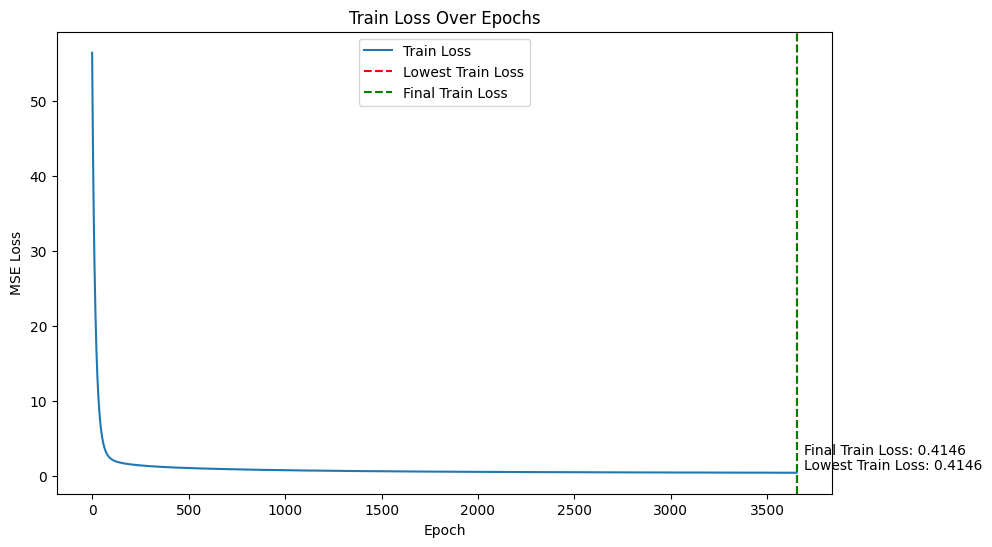

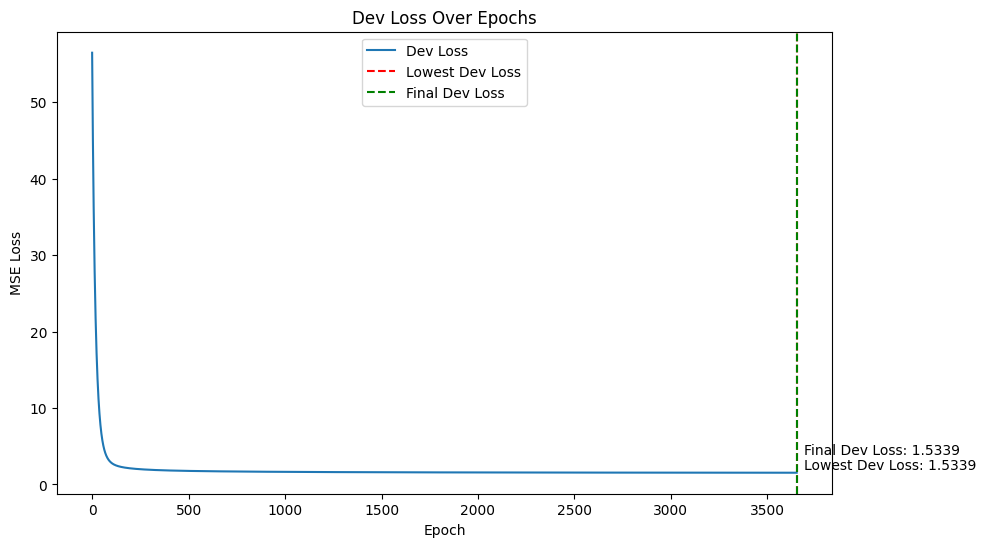

In [53]:
# Compute average loss histories
average_train_history = np.mean(all_train_history, axis=0)
average_dev_history = np.mean(all_dev_history, axis=0)

# Find the lowest loss values
lowest_train_loss = min(average_train_history)
lowest_dev_loss = min(average_dev_history)

# Get final loss values
final_train_loss = average_train_history[-1]
final_dev_loss = average_dev_history[-1]

# Plot the loss histories
plot_loss(average_train_history, lowest_train_loss, final_train_loss, "Train")
plot_loss(average_dev_history, lowest_dev_loss, final_dev_loss, "Dev")

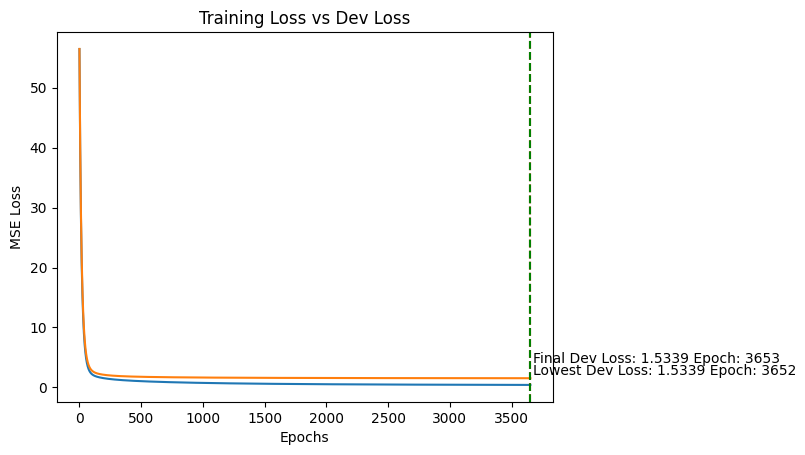

In [54]:
# Compute average loss histories
average_train_history = np.mean(all_train_history, axis=0)
average_dev_history = np.mean(all_dev_history, axis=0)

# Compare train and dev loss
lowest_dev_loss = min(average_dev_history)
lowest_dev_epoch = np.argmin(average_dev_history)

final_dev_loss = average_dev_history[-1]
final_dev_epoch = final_loss_epoch = len(average_dev_history)

plt.plot(range(len(average_train_history)), average_train_history)
plt.plot(range(len(average_dev_history)), average_dev_history)

plt.axvline(x=lowest_dev_epoch, color='r', linestyle='--', label='Lowest Dev Loss')
plt.text(lowest_dev_epoch*1.005, lowest_dev_loss, f'Lowest Dev Loss: {lowest_dev_loss:.4f} Epoch: {lowest_dev_epoch}', color='black', verticalalignment='bottom')

plt.axvline(x=final_dev_epoch, color='green', linestyle='--', label='Final Dev Loss')
plt.text(final_dev_epoch*1.005, final_dev_loss+2, f'Final Dev Loss: {final_dev_loss:.4f} Epoch: {final_dev_epoch}', color='black', verticalalignment='bottom')

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Dev Loss')

plt.show()


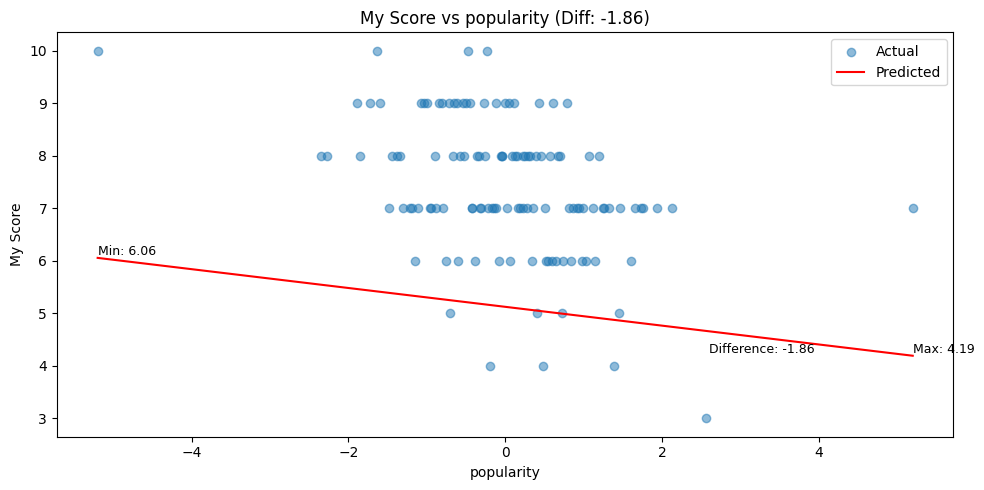

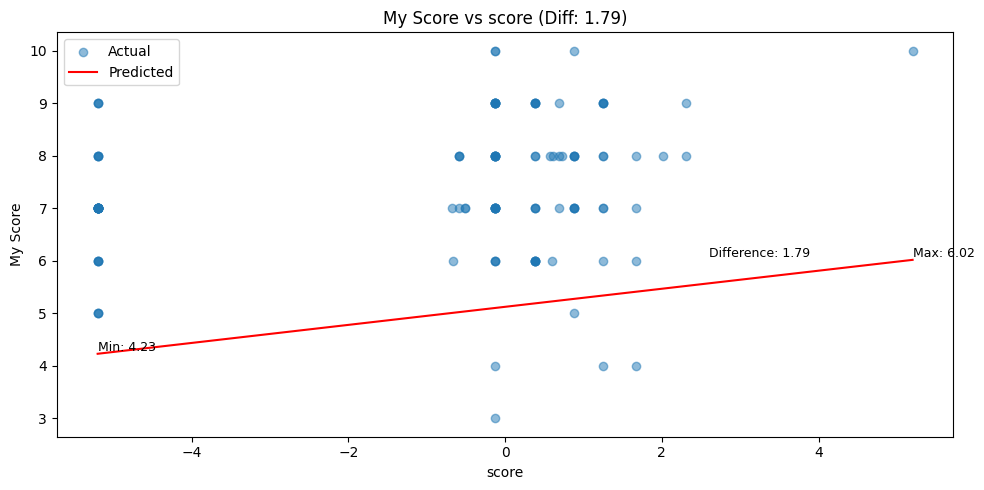

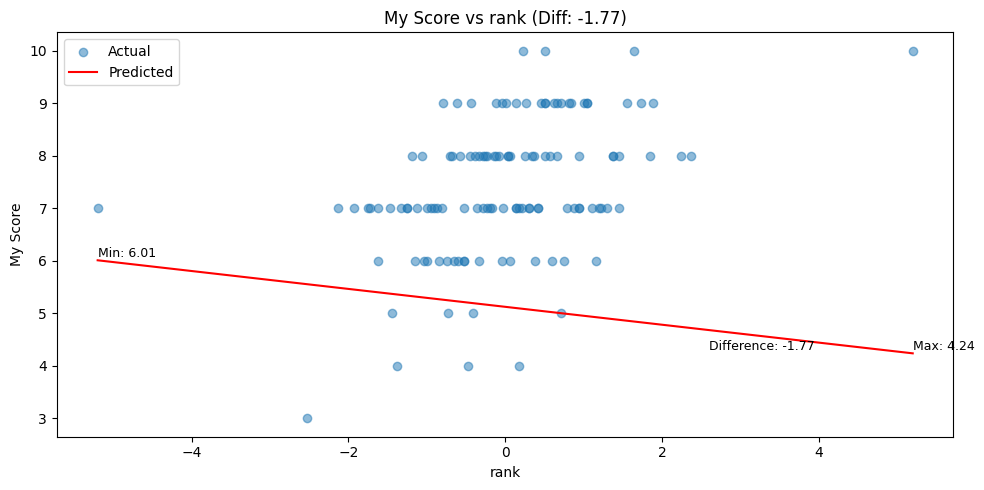

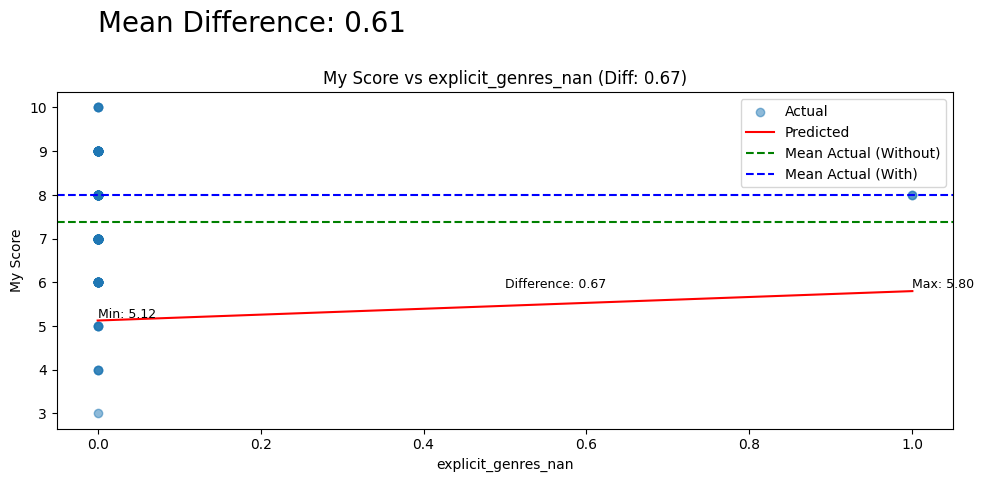

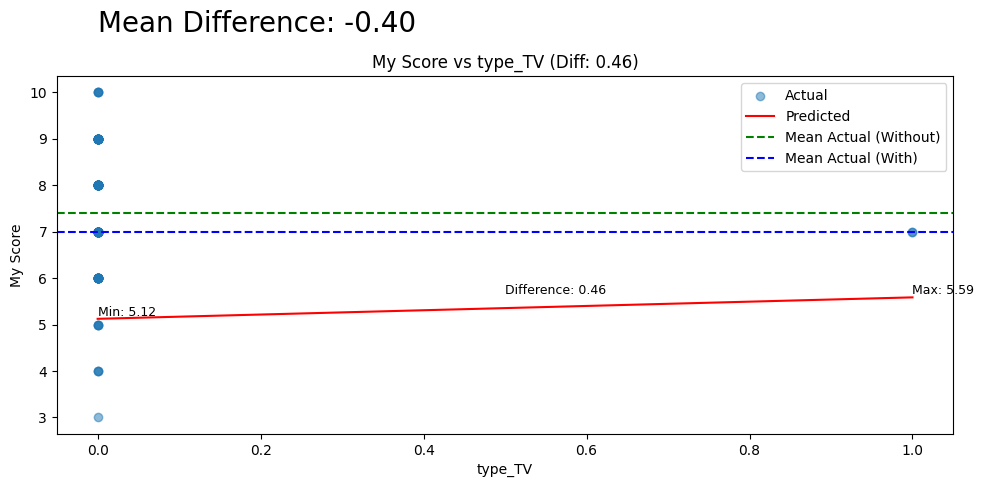

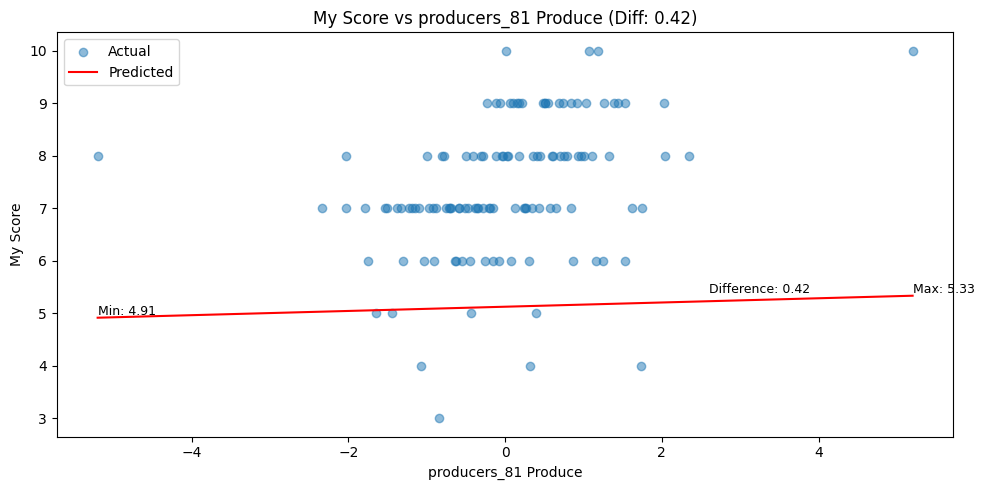

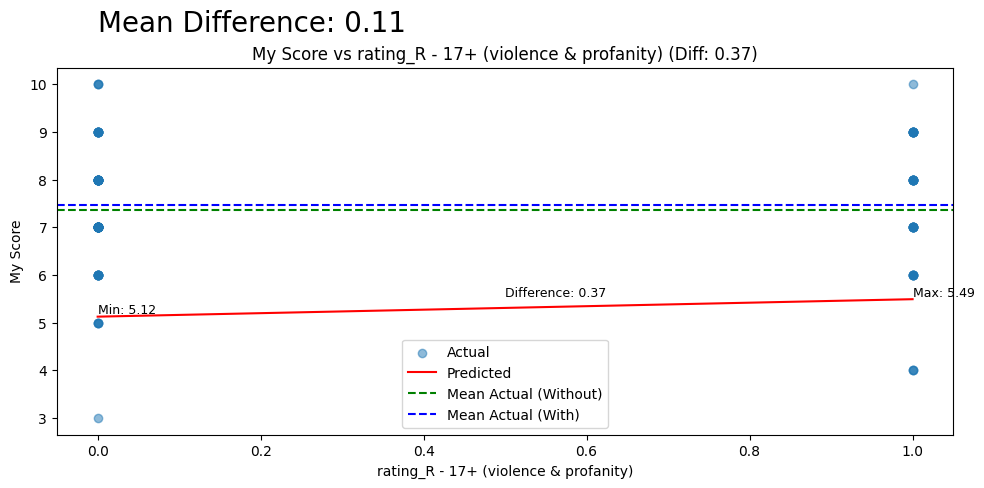

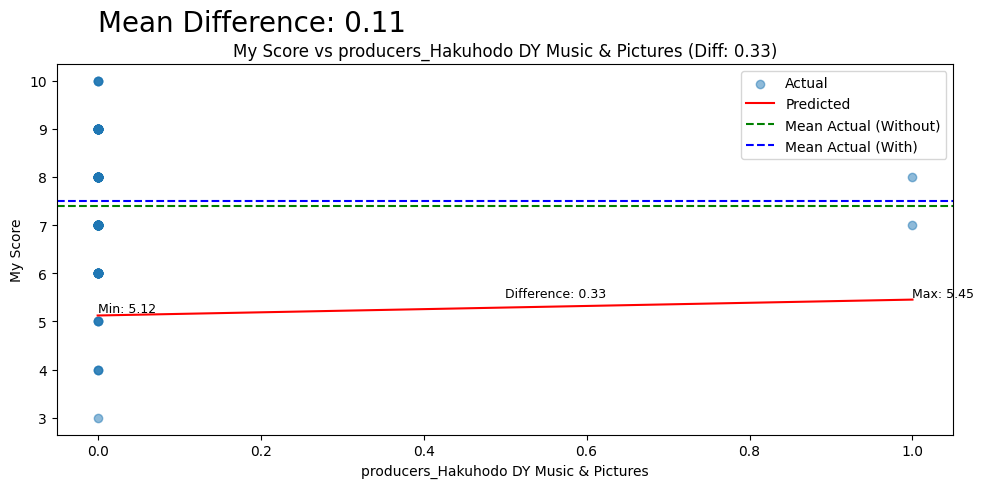

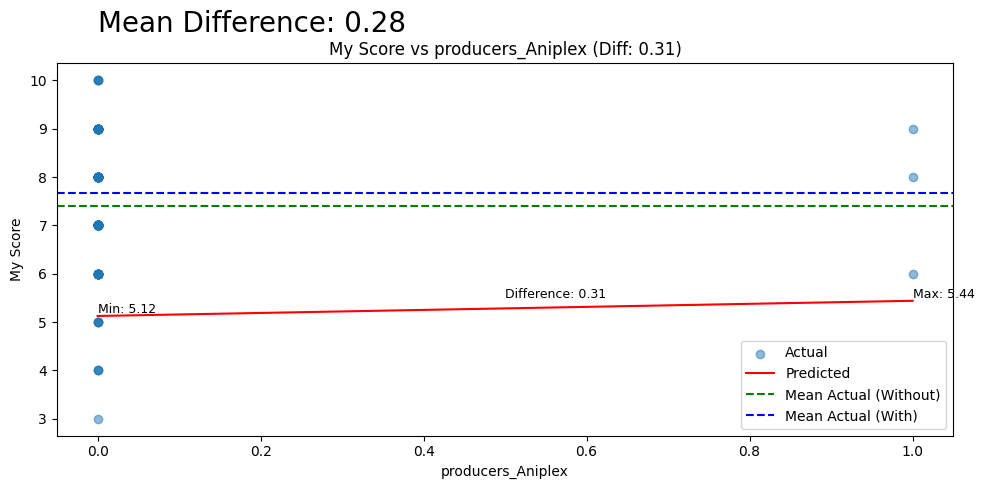

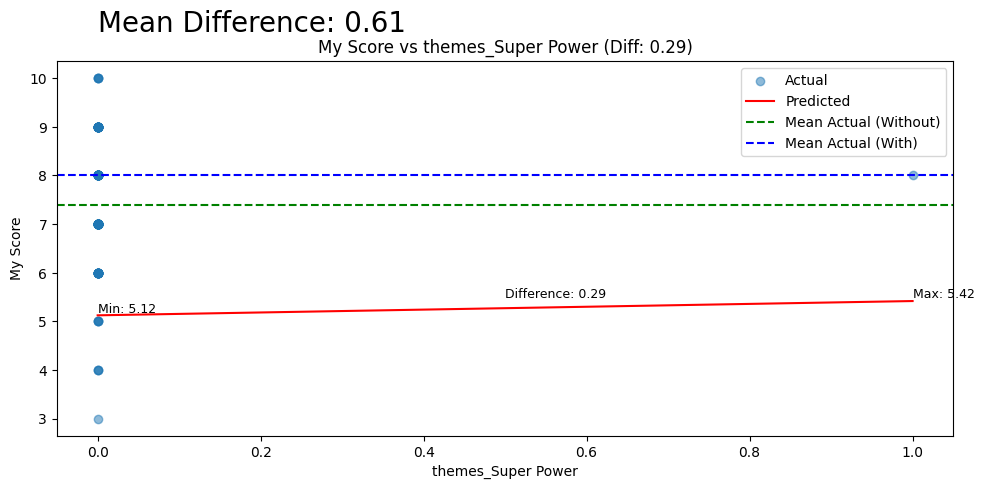

In [56]:
import matplotlib.pyplot as plt

# Define the number of features to plot per figure (excluding the bias term)
features_per_figure = 10

# Set Target Column
target_column = 'my_score'

# Separate titles for each set
train_titles = df['title']

columns_to_standardize = ['episodes', 'score', 'rank', 'popularity', 'favorites']

# Drop non-feature columns and preprocess the data
x_train_full, y_train_full = preprocess_data(df, scaler, target_column, columns_to_standardize)

# Extract feature names
feature_names = df.drop(['series_animedb_id', 'title', 'my_score'], axis=1).columns.tolist()

# Calculate the differences for all features
feature_diffs = []
for feature_idx, feature_name in enumerate(feature_names):
    x_min, x_max = x_train_full[:, feature_idx].min(), x_train_full[:, feature_idx].max()
    y_pred_min = theta[0] + theta[feature_idx + 1] * x_min
    y_pred_max = theta[0] + theta[feature_idx + 1] * x_max
    y_pred_diff = y_pred_max - y_pred_min
    feature_diffs.append((feature_name, y_pred_diff))

# Sort features based on the absolute difference
sorted_features = sorted(feature_diffs, key=lambda x: abs(x[1]), reverse=True)


# Plot graphs for features with the largest differences first
for feature_name, _ in sorted_features[:features_per_figure]:  # Limit to `features_per_figure` features
    feature_idx = feature_names.index(feature_name)
    fig, ax = plt.subplots(figsize=(10, 5))

    # Scatter plot for actual data points for feature
    ax.scatter(x_train_full[:, feature_idx], y_train_full, label='Actual', alpha=0.5)

    # Compute predictions using only the current feature
    y_pred_single_feature = theta[0] + theta[feature_idx + 1] * x_train_full[:, feature_idx]

    # Sorting values for a neat line plot
    sorted_indices = np.argsort(x_train_full[:, feature_idx])
    ax.plot(x_train_full[sorted_indices, feature_idx], y_pred_single_feature[sorted_indices], color='red', label='Predicted')

    # Add text annotations to the plot
    x_min, x_max = x_train_full[:, feature_idx].min(), x_train_full[:, feature_idx].max()
    y_pred_min = theta[0] + theta[feature_idx + 1] * x_min
    y_pred_max = theta[0] + theta[feature_idx + 1] * x_max
    y_pred_diff = y_pred_max - y_pred_min

    ax.text(x_min, y_pred_min, f"Min: {y_pred_min:.2f}", fontsize=9, verticalalignment='bottom')
    ax.text(x_max/2, y_pred_max, f"Difference: {y_pred_diff:.2f}", fontsize=9, verticalalignment='bottom')
    ax.text(x_max, y_pred_max, f"Max: {y_pred_max:.2f}", fontsize=9, verticalalignment='bottom')

    # Calculate mean scores for binary features
    if np.array_equal(x_train_full[:, feature_idx], x_train_full[:, feature_idx].astype(bool)):  # Check if feature is binary
        mean_score_0 = np.mean(y_train_full[x_train_full[:, feature_idx] == 0])
        mean_score_1 = np.mean(y_train_full[x_train_full[:, feature_idx] == 1])
        mean_difference = mean_score_1 - mean_score_0
        ax.axhline(y=mean_score_0, color='green', linestyle='--', label='Mean Actual (Without)')
        ax.axhline(y=mean_score_1, color='blue', linestyle='--', label='Mean Actual (With)')
        ax.text(x_max-1, y_pred_max*2, f"Mean Difference: {mean_difference:.2f}", fontsize=20, verticalalignment='bottom')

    ax.set_xlabel(feature_name)
    ax.set_ylabel('My Score')
    ax.set_title(f'My Score vs {feature_name} (Diff: {y_pred_diff:.2f})')
    ax.legend()

    plt.tight_layout()
    plt.show()

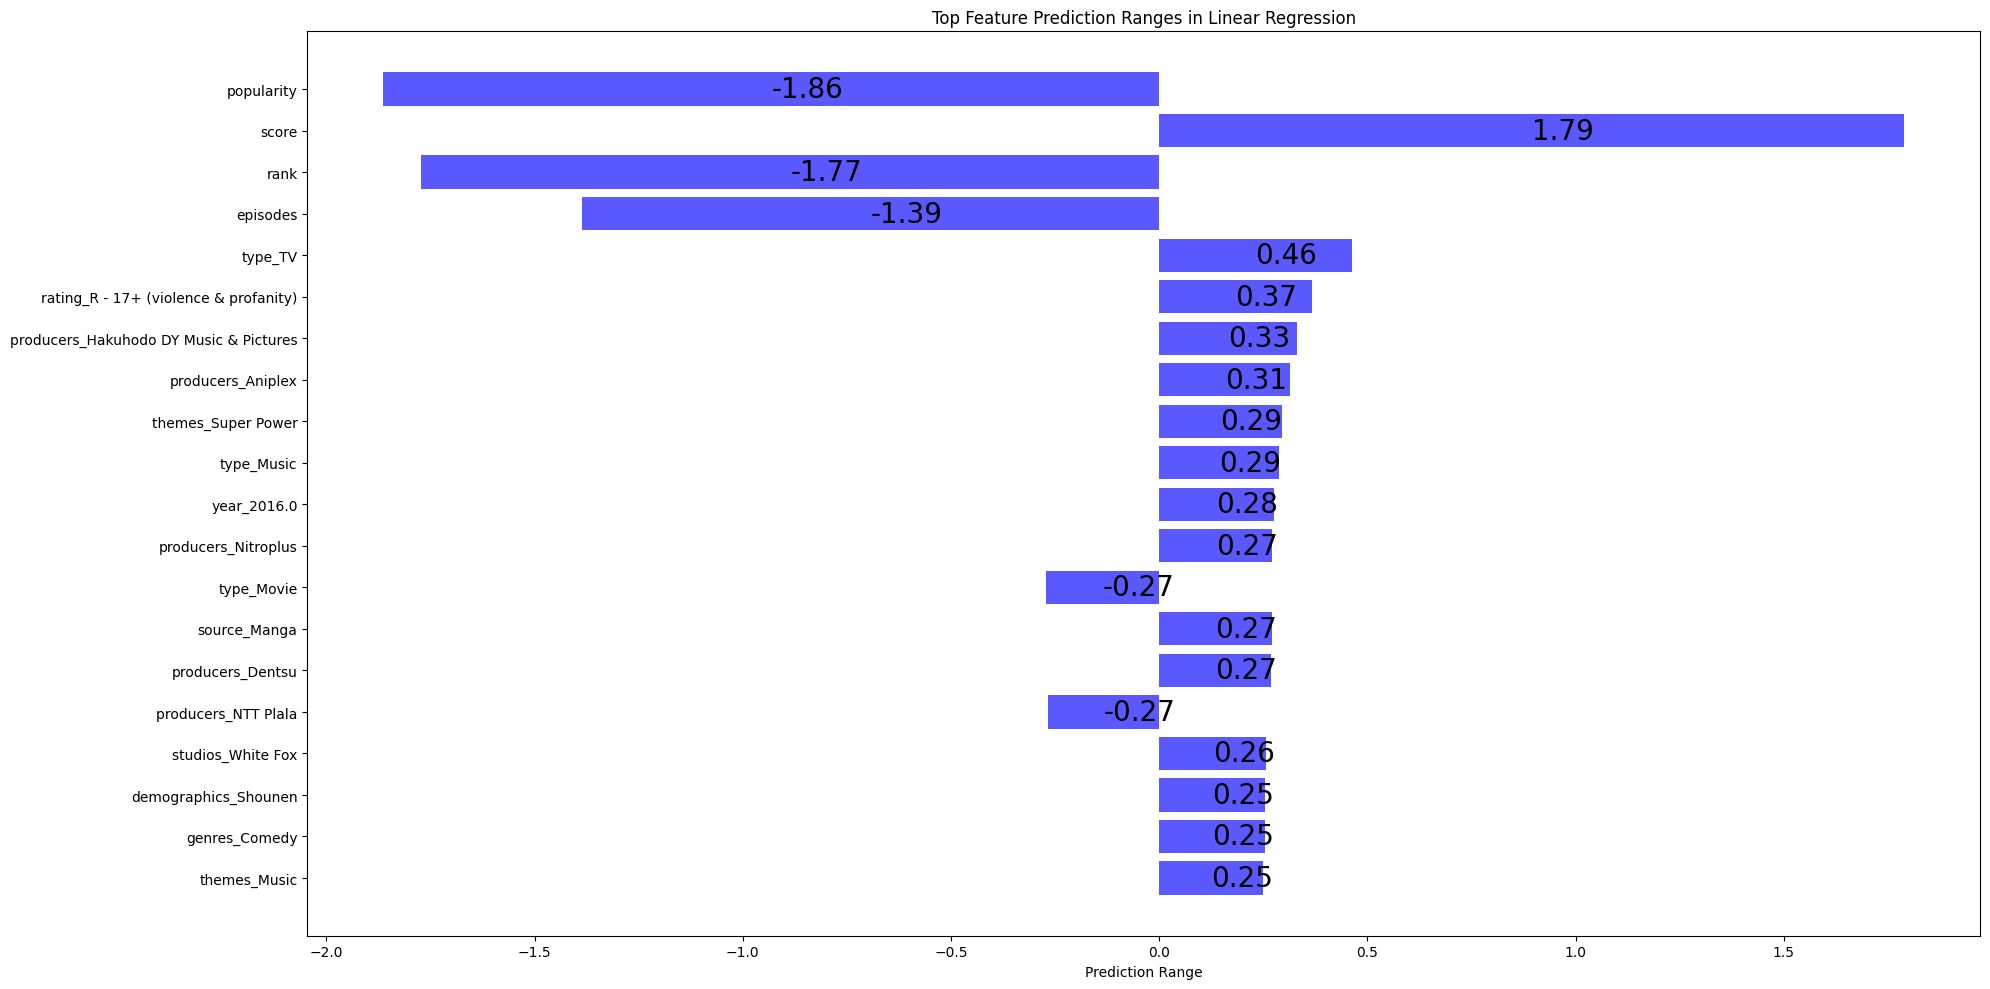

In [57]:
figsize = (20, 10)
fontsize = 10
feature_limit = 20  # Limit the number of features to display

# Calculate the differences for all features
feature_diffs = []
for feature_idx, feature_name in enumerate(feature_names):
    x_idx = feature_idx + 1  # Adjust for bias term
    x_min, x_max = x_train_full[:, x_idx].min(), x_train_full[:, x_idx].max()
    y_pred_min = theta[0] + theta[x_idx] * x_min
    y_pred_max = theta[0] + theta[x_idx] * x_max
    y_pred_diff = y_pred_max - y_pred_min
    feature_diffs.append((feature_name, y_pred_diff))

# Sort features based on the prediction range
sorted_features = sorted(feature_diffs, key=lambda x: abs(x[1]), reverse=True)
top_sorted_features = sorted_features[:feature_limit]  # Selecting top N features

# Plot
plt.figure(figsize=figsize)
plt.title("Top Feature Prediction Ranges in Linear Regression", fontsize=fontsize + 2)


# Create horizontal bars
bars = plt.barh(range(len(top_sorted_features)), [val for _, val in top_sorted_features], color='b', align='center', alpha=0.65)

# Add text annotations next to each bar
for bar, (feature, impact) in zip(bars, top_sorted_features):
    plt.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{impact:.2f}', va='center', fontsize=20, color='black')

plt.yticks(range(len(top_sorted_features)), [name for name, _ in top_sorted_features], fontsize=fontsize)
plt.gca().invert_yaxis()  # Reverse the order to have the largest at the top

plt.xlabel('Prediction Range', fontsize=fontsize)
plt.tight_layout()  # Adjust layout to fit better
plt.show()

In [58]:
def display_predictions(x, y, titles, theta, max_title_length=20):
    # Predict scores for all series in the set
    predicted_scores = x.dot(theta)

    # Create a list to hold title, actual score, predicted score, and absolute difference
    predictions = []

    for i in range(len(predicted_scores)):
        actual_score = y[i]
        predicted_score = predicted_scores[i]
        series_title = titles.iloc[i]

        # Calculate the absolute difference
        difference = abs(actual_score - predicted_score)

        # Truncate the title if it's longer than the maximum length
        if len(series_title) > max_title_length:
            series_title = series_title[:max_title_length] + "..."

        predictions.append((series_title, actual_score, predicted_score, difference))

    # Create a DataFrame from the predictions list
    df_predictions = pd.DataFrame(predictions, columns=['Title', 'Actual Score', 'Predicted Score', 'Difference'])

    # Sort the DataFrame by the 'Difference' column in descending order
    df_predictions = df_predictions.sort_values(by='Difference', ascending=False)

    return df_predictions

In [59]:
# Display predictions for the training set
predictions_df = display_predictions(x_train_full, y_train_full, train_titles, early_theta)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(predictions_df)

,Title,Actual Score,Predicted Score,Difference
115,Tokyo Ghoul:re 2nd S...,3,5.948818,2.948818
114,Tokyo Ghoul:re,7,5.203842,1.796158
11,Chuunibyou demo Koi ...,9,7.411020,1.588980
117,Vinland Saga Season ...,10,8.505422,1.494578
0,"Ame wo Matsu,",8,6.518215,1.481785
61,Kimetsu no Yaiba,6,7.272137,1.272137
75,Mahou Shoujo Madoka★...,10,8.739550,1.260450
118,Violet Evergarden,6,7.213084,1.213084
105,Shinseiki Evangelion,4,5.095073,1.095073
51,Kaguya-sama wa Kokur...,9,7.923777,1.076223


In [69]:
print(early_theta)

[ 2.60401206e+00 -2.37178493e-01  1.77375802e-01 -1.74547611e-01
 -1.33098095e-01  1.33707958e-02  6.13790954e-02  1.02275326e-01
 -5.65575491e-02 -6.97592297e-02  1.13754633e-01  2.09187842e-01
  4.76773753e-01  8.85087871e-02 -6.65088625e-02  1.13189380e-01
 -2.20891503e-01  7.19368864e-02  6.08433739e-02  1.94065934e-02
  3.93605893e-03  3.74134377e-02  3.93605893e-03  9.95131342e-03
 -3.78260474e-02  3.74134377e-02  1.17125439e-01  1.13189380e-01
  9.88293209e-02  2.19999246e-02  3.82673722e-02  7.67864797e-02
 -3.70862857e-02  7.61580184e-02  7.17714427e-02  8.68837523e-03
  2.82939044e-01 -9.18160931e-02  3.91047123e-02 -4.59256306e-02
 -3.39428208e-02 -1.58572336e-01  1.03477316e-01 -3.08512695e-02
  5.87446327e-02  9.95131342e-03 -6.47289150e-02  5.87446327e-02
  5.50199161e-02  7.61580184e-02 -1.62016925e-01 -1.14141071e-02
  8.85087871e-02 -4.39047511e-02  3.93605893e-03  4.10492867e-01
 -3.41815405e-02  1.53625336e-01 -3.08512695e-02  1.54006325e-01
  7.61580184e-02  7.76022

In [75]:
theta.dtype

dtype('float64')

In [60]:
anime_id = 413
single_show_df = process_single_show(anime_id, df, split_and_encode, preprocess_custom, scaler, early_theta)

# Display result
display(single_show_df)

,Title,Predicted Score
0,Hametsu no Mars,4.393878


In [61]:
anime_id = 5114
single_show_df = process_single_show(anime_id, df, split_and_encode, preprocess_custom, scaler, early_theta)

# Display result
display(single_show_df)
print(predictions_df.loc[33])

,Title,Predicted Score
0,Fullmetal Alchemist: Brotherhood,9.350652


Title              Fullmetal Alchemist:...
Actual Score                            10
Predicted Score                   9.350652
Difference                        0.649348
Name: 33, dtype: object


In [62]:
def fetch_anime_data(data_type, identifier=None, page=1):
    if data_type == 'season':
        url = f'https://api.jikan.moe/v4/seasons/{identifier}'
    elif data_type == 'top':
        url = f'https://api.jikan.moe/v4/top/anime?page={page}'
    else:
        raise ValueError("Invalid data_type. Must be 'season' or 'top'")

    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()['data']
        else:
            print(f"Failed to fetch anime data, Status Code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching anime data: {e}")
        return None

In [64]:
import time
def process_and_predict(raw_anime_data, df, split_and_encode, preprocess_custom, scaler, theta):
    results = []
    for anime in raw_anime_data:
        anime_id = anime['mal_id']
        single_show_df = process_single_show(anime_id, df, split_and_encode, preprocess_custom, scaler, theta)
        time.sleep(1)
        if not single_show_df.empty:
            results.append(single_show_df)

    if results:
        final_df = pd.concat(results, ignore_index=True)
        final_df = final_df.sort_values(by='Predicted Score', ascending=False)
        return final_df
    else:
        print("No data found.")
        return pd.DataFrame(columns=['Title', 'Predicted Score'])

In [65]:
raw_top_data = fetch_anime_data('top', page=1)
raw_season_data = fetch_anime_data('season', '2023/fall')

In [66]:
top_df = process_and_predict(raw_top_data, df, split_and_encode, preprocess_custom, scaler, early_theta)
season_df = process_and_predict(raw_season_data, df, split_and_encode, preprocess_custom, scaler, early_theta)

<ipython-input-27-14820c1aa9d7>:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features = df_features.fillna(0)


In [67]:
top_df

,Title,Predicted Score
0,Sousou no Frieren,9.631824
13,Bleach: Sennen Kessen-hen - Soukoku-tan,9.488865
2,Fullmetal Alchemist: Brotherhood,9.350652
14,Gintama.,8.964151
21,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,8.938532
6,Gintama: The Final,8.932770
4,Shingeki no Kyojin Season 3 Part 2,8.827094
9,Gintama': Enchousen,8.817218
5,Gintama°,8.544137
7,Gintama',8.517825


In [68]:
season_df

,Title,Predicted Score
0,Sousou no Frieren,9.631824
8,Undead Unluck,7.585621
1,Spy x Family Season 2,7.471061
9,Kimi no Koto ga Daidaidaidaidaisuki na 100-nin...,7.459719
4,Kage no Jitsuryokusha ni Naritakute! 2nd Season,7.449770
7,Dr. Stone: New World Part 2,7.091007
10,Ragna Crimson,7.013235
6,"Shangri-La Frontier: Kusoge Hunter, Kamige ni ...",7.009575
2,Kusuriya no Hitorigoto,6.994178
16,Spy x Family Movie: Code: White,6.979670


In [71]:
import joblib
model = joblib.load('/content/model_lr_0.0025_lambda_5.pkl')

In [74]:
model.shape

(283,)